<a href="https://colab.research.google.com/github/parthvijoshi/BA820_Project_Team05/blob/main/AloneTV_M2_Abbinaya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ALONE TV SHOW
## Why we chose this project?
Alone is s survival TV series where 10 survivalists are dropped in an extremely remote area (Arctic winter) and must fend for themselves. Its impressive to see how the winning contestants use their skills, endurance, and mental fortitude to last 100 days in such a harsh living condition.

## Data Description
It uses a collection of datasets about the TV series:

1. `survivalists.csv`
A data frame of survivalists across all 9 seasons detailing name and demographics, location and profession, result, days lasted, reasons for tapping out (detailed and categorised), page URL.

| Feature Name   | Description |
| -------- | ------- |
| `season`  | The season number   |
| `name` | Name of the survivalist     |
| `version` | The version country code (currently only US but being preppred or other versions)|
| `id` | Survivalist unique ID |
| `age` | Age of survivalist |
| `gender` | Gender |
| `city` |  City |
| `state` | State |
| `country` | Country |
|`result`| Place the survivalist finished in the season|
| `days_lasted` | The number of days lasted in the game before tapping out or winning|
| `medically_evacuated` | Logical. If the survivalist was medically evacuated from the game |
| `reason_tapped_out` | The reason the survivalist tapped out of the game. NA means they were the winner |
| `reason_category` | A simplified category of the reason for tapping out |
| `team` | The team they were associated with (only for season 4)|
| `day_linked_up` | Day the team members linked up |
| `profession` | Profession of the survivalist |
---

2. `episodes.csv`
This dataset contains details of each episode including the title, number of viewers, beginning quote and IMDb rating.

| Feature Name   | Description |
| -------- | ------- |
| `version` | Country code for the version of the show |
| `season` | The season number |
| `episode_number_overall` | Episode number across seasons |
| `episode` | Episode number |
| `title` | Episode title |
| `air_date` | Date the episode originally aired |
| `viewers` | Number of viewers in the US (millions) |
| `quote` | The beginning quote |
| `author` | Author of the beginning quote |
|`imdb_rating` | IMDb rating of the episode |
| `n_ratings` | Number of ratings given for the episode |
----

3. `seasons.csv`
The season summary dataset includes location, latitude and longitude, and other season level information. It includes the date of drop off where the information exists.

| Feature Name   | Description |
| -------- | ------- |
| `version` | Country code for the version of the show |
| `season` | The season number |
| `location` | Location |
| `country` | Country |
| `n_survivors` | Number of survivalists in the season. In season 4 there were 7 teams of 2 |
| `lat` | Latitude |
| `lon` | Longitude |
| `date_drop_off` | The date the survivalists were dropped off |
---

4. `loadouts.csv`
Each survivalist is allowed to take with them 10 items. This dataset includes information on each survivalist’s loadout.

| Feature Name   | Description |
| -------- | ------- |
| `version` | Country code for the version of the show |
| `season` | The season number |
| `id` | Survivalist unique ID |
| `name` | Name of the survivalist |
| `item_number` | Item number |
| `item_detailed` | Detailed loadout item description |
| `item` | Loadout item. Simplified for aggregation |

## EDA

#### Mounting from drive for csv files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importing necessary libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np

Reading and Merging csv files into one dataframe

In [3]:
epi = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/BA820TeamProject/Phase1/AloneTVshow/episodes.csv')
ses = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/BA820TeamProject/Phase1/AloneTVshow/seasons.csv')
sur = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/BA820TeamProject/Phase1/AloneTVshow/survivalists.csv')
load = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/BA820TeamProject/Phase1/AloneTVshow/loadouts.csv')


Merging episode level and contestant level data duplicates the rows

In [4]:
import pandas as pd

# -----------------------------
# 1. Normalize version column
# -----------------------------
for _df in [epi, ses, sur, load]:
    if 'version' not in _df.columns:
        _df['version'] = 'US'


if 'id' not in sur.columns:
    sur = sur.copy()
    sur['id'] = sur['name']  # fallback to name as unique identifier

if 'id' not in load.columns:
    load = load.copy()
    load['id'] = load['name']  # fallback for loadouts
# -------------------------------------------------
# 2. PERSON–SEASON dataframe (canonical df)
# -------------------------------------------------
df = (
    sur.merge(
        ses[['version','season','location','lat','lon','date_drop_off']],
        on=['version','season'],
        how='left'
    )
    .groupby(['version','season','id','name'], as_index=False)
    .agg({
        'age': 'first',
        'gender': 'first',
        'profession': 'first',
        'city': 'first',
        'state': 'first',
        'country': 'first',
        'days_lasted': 'max',
        'result': 'first',
        'medically_evacuated': 'first',
        'reason_category': 'first',
        'location': 'first',
        'lat': 'first',
        'lon': 'first',
        'date_drop_off': 'first'
    })
)

# Hard guarantee: no duplicate people
assert df[['version','season','id']].duplicated().sum() == 0


# -------------------------------------------------
# 3. EPISODE DATA → season-level aggregation
# -------------------------------------------------
epi_season = (
    epi.groupby(['version','season'], as_index=False)
       .agg({
           'viewers': 'mean',
           'imdb_rating': 'mean',
           'n_ratings': 'mean'
       })
)

df = df.merge(
    epi_season,
    on=['version','season'],
    how='left'
)


# -------------------------------------------------
# 4. LOADOUT DATA → collapse per person
# -------------------------------------------------
load_person = (
    load[['version','season','id','item']]
    .drop_duplicates()
    .groupby(['version','season','id'], as_index=False)
    .agg({'item': list})
)

df = df.merge(
    load_person,
    on=['version','season','id'],
    how='left'
)


In [5]:
df_person_season = df.groupby(['version','season','name'], as_index=False).agg({
    'days_lasted': 'max',
    'age': 'first',
    'gender': 'first'
    # add more as needed
})
df_person_season.head()


,version,season,name,days_lasted,age,gender
0,US,1,Alan Kay,56,40,Male
1,US,1,Brant McGee,6,44,Male
2,US,1,Chris Weatherman,1,41,Male
3,US,1,Dustin Feher,8,37,Male
4,US,1,Joe Robinet,4,24,Male


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   version              94 non-null     object 
 1   season               94 non-null     int64  
 2   id                   94 non-null     object 
 3   name                 94 non-null     object 
 4   age                  94 non-null     int64  
 5   gender               94 non-null     object 
 6   profession           94 non-null     object 
 7   city                 94 non-null     object 
 8   state                93 non-null     object 
 9   country              94 non-null     object 
 10  days_lasted          94 non-null     int64  
 11  result               94 non-null     int64  
 12  medically_evacuated  94 non-null     bool   
 13  reason_category      84 non-null     object 
 14  location             94 non-null     object 
 15  lat                  94 non-null     float

Most of the missing values are present in `day_linked_up`, `team` as some of seasons required team participation

## Preliminary Exploratory Data Analysis

#### **Correlation Mapping**

<Axes: >

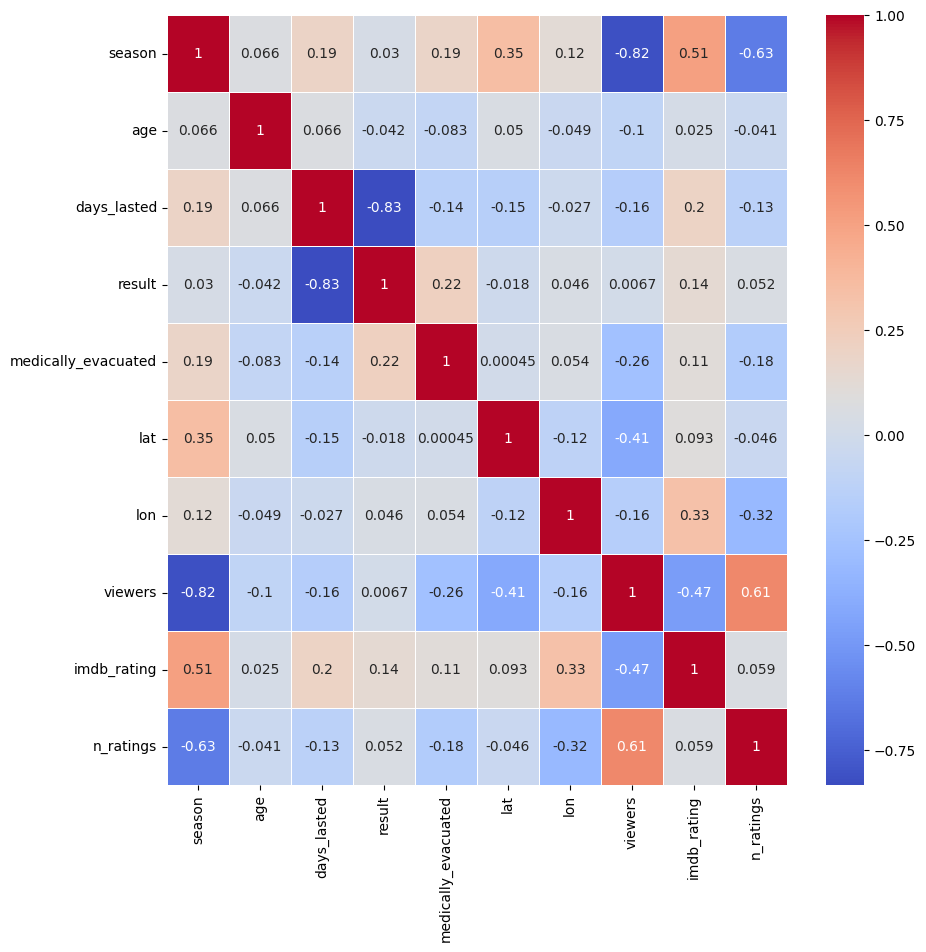

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(numeric_only=True), annot = True,cmap="coolwarm",linewidths=0.5, ax = ax)

**Inference:**
This correlation heatmap suggests only a few moderate linear relationships among the numeric variables, most correlations are weak.

* Season seems moderately related to viewership metrics
* Days lasted is strongly related to the result variable
* Medical evacuation, latitude/longitude, and age show only very small correlations with outcome and viewership, suggesting no strong simple linear effect from these factors alone.

#### **Viewership vs Seasons**

<Figure size 600x400 with 0 Axes>

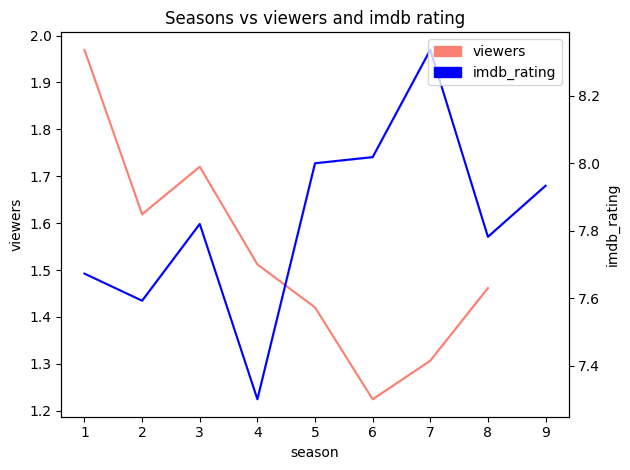

In [8]:

plt.figure(figsize=(6,4))
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
sns.lineplot(
    data=df,
    x='season',
    y='viewers',
    color = 'salmon',
    ax = ax1
)
sns.lineplot(
    data=df,
    x='season',
    y='imdb_rating',
    color = 'blue',
    ax = ax2
)
plt.title('Seasons vs viewers and imdb rating')

sal_patch = mpatches.Patch(color='salmon', label='viewers')
blue_patch = mpatches.Patch(color='blue', label='imdb_rating')
plt.legend(loc = "upper right",handles=[sal_patch, blue_patch])
plt.tight_layout()
plt.show()


**Inference**: Viewership clearly peaks in Season 1 and then declines in later seasons, while IMDb ratings gradually improve or stay high across later seasons.
This suggests initial viewership was strongest at launch.

#### **Location effect on survivals days lasted and how  imdb rating were imapcted**

<Figure size 1000x500 with 0 Axes>

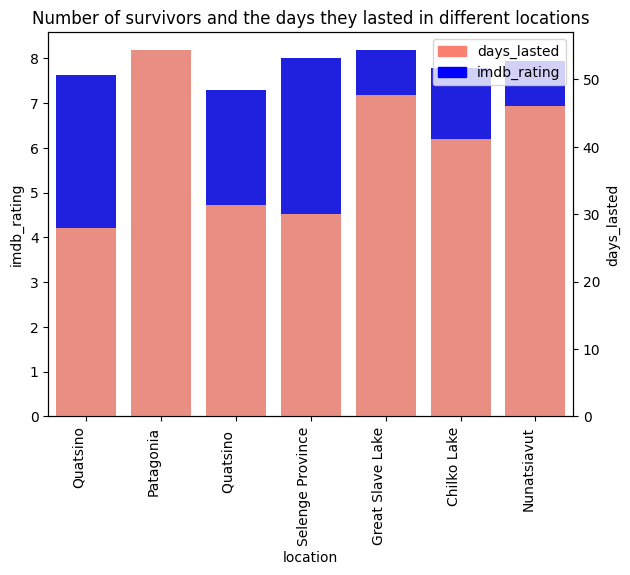

In [9]:
plt.figure(figsize=(10,5))
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
sns.barplot(
    data=df,
    y='imdb_rating',
    x='location',
    color = 'blue',
    # legend = True, # Removed as it's not needed with manual patch legend
    ax = ax1,
    errorbar=None
)
sns.barplot(
     data=df,
     x='location',
     y='days_lasted',
     color = 'salmon',
     # legend=True, # Removed as it's not needed with manual patch legend
     ax = ax2,
     errorbar=None
 )

plt.title('Number of survivors and the days they lasted in different locations')
plt.tight_layout()
# plt.legend(loc= "upper left") # Removed this line due to UserWarning and redundancy
blu_patch = mpatches.Patch(color='blue', label='imdb_rating')
sal_patch = mpatches.Patch(color='salmon', label='days_lasted')
plt.legend(loc = "upper right",handles=[sal_patch, blu_patch])

# Fix the tick locations before setting labels to prevent UserWarning
ax1.set_xticks(ax1.get_xticks())
# Rotate x-axis labels on ax1
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right')
plt.show()

**Inference:** Survival durations vary noticeably by location, but higher IMDb ratings tend to align with locations where contestants did not necessarily last the longest.

This pattern suggests that tougher locations deliver engaging episodes that viewers rate highly, while easier environments do not get better audience ratings.

####  **Days lasted vs age**

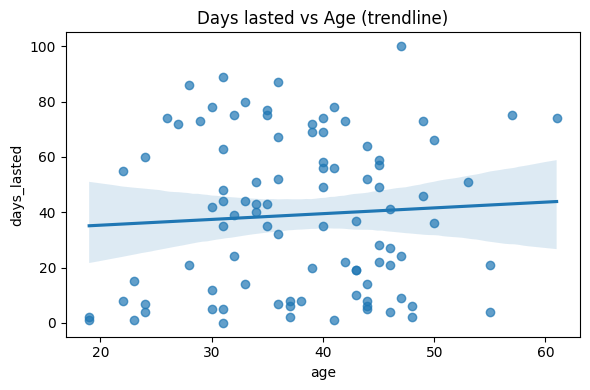

In [10]:
plt.figure(figsize=(6,4))
sns.regplot(
    data=df,
    x='age',
    y='days_lasted',
    scatter_kws={'alpha':0.7}
)
plt.title('Days lasted vs Age (trendline)')
plt.tight_layout()
plt.show()


**Inference:**
The scatter plot shows a very weak trend between age and days lasted, with wide spread around the line.

Overall, age does not appear to have a strong impact on how long contestants survive.

#### **Days lasted by reason_category**

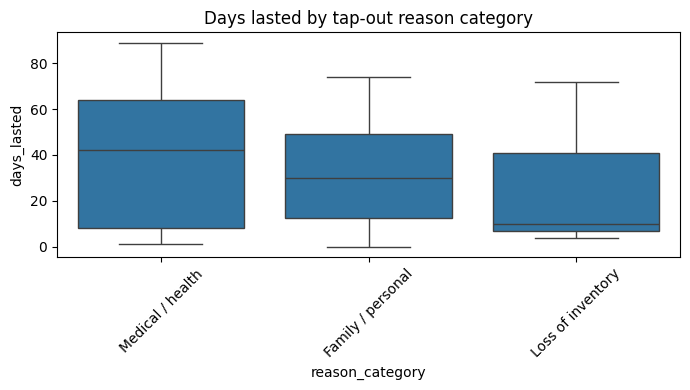

In [11]:
plt.figure(figsize=(7,4))
sns.boxplot(
    data=df,
    x='reason_category',
    y='days_lasted'
)
plt.xticks(rotation=45)
plt.title('Days lasted by tap-out reason category')
plt.tight_layout()
plt.show()


**Inference:**
Contestants who tap out for medical or health reasons tend to leave earlier, compared with those who leave for family/personal reasons.
Participants exiting due to loss of inventory generally have the shortest stays.

<BarContainer object of 94 artists>

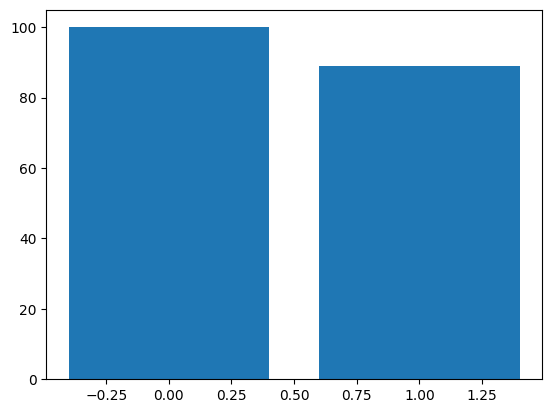

In [12]:
df['medically_evacuated'] = df['medically_evacuated'].astype('category')
plt.bar(df['medically_evacuated'], df['days_lasted'])

**Inference:**
Contestants who are medically evacuated tend to stay slightly fewer days on average than those who are not, indicating health issues cut some runs short.

#### **Winner profile**

In [13]:
df[df['result'] == 1]['age'].value_counts()

,count
age,
40,2
35,2
50,1
36,1
32,1
24,1
47,1
30,1


In [14]:
df[df['result'] == 1]['gender'].value_counts()

,count
gender,
Male,10


In [15]:
df[df['result'] == 1]['profession'].value_counts()

,count
profession,
Corrections Officer,1
Writer and Former Missionary,1
Boat builder,1
Freelance Writer,1
Adventure Videographer,1
Wilderness Skills Instructor,1
Construction,1
Hunting Guide,1
Professional Bowyer & Hunter,1


In [16]:
df[df['result'] == 1]['country'].value_counts()

,count
country,
United States,7
Canada,3


**Inference:** The winner for all 9 seasons of "Alone" were United States males around the range of age from 30 to 40 with a variety of professional background from a writer to a construction worker.

### **Winner Profile items used for survival**

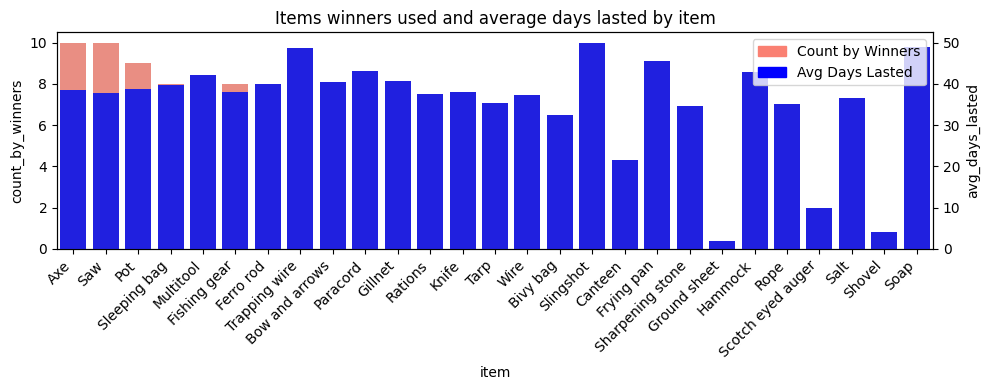

In [17]:
fig, ax1 = plt.subplots(figsize=(10,4))

df1 = df[df['result'] == 1]

# Data for winner items count
exploded_df1 = df1.explode('item')
winner_item_counts = exploded_df1['item'].value_counts().reset_index()
winner_item_counts.columns = ['item', 'count_by_winners']

# Data for average days lasted per item (across all participants)
exploded_df_all = df.explode('item')
avg_days_per_item = exploded_df_all.groupby('item')['days_lasted'].mean().reset_index()
avg_days_per_item.columns = ['item', 'avg_days_lasted']

# Merge the two dataframes to ensure consistent item order for plotting
# Use outer merge to include all items if one dataset has an item the other doesn't
plot_data = pd.merge(winner_item_counts, avg_days_per_item, on='item', how='outer').fillna(0) # Fill NaN if an item is not in one group

# Sort by count_by_winners for better visualization
plot_data = plot_data.sort_values(by='count_by_winners', ascending=False)

sns.barplot(
    data=plot_data,
    x='item',
    y='count_by_winners',
    color='salmon',
    ax=ax1,
    errorbar=None
)

ax2 = ax1.twinx()

sns.barplot(
    data=plot_data,
    x='item',
    y='avg_days_lasted',
    color='blue',
    ax=ax2,
    errorbar=None
)

plt.title('Items winners used and average days lasted by item')

for label in ax1.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

plt.tight_layout()

sal_patch = mpatches.Patch(color='salmon', label='Count by Winners')
blu_patch = mpatches.Patch(color='blue', label='Avg Days Lasted')
plt.legend(handles=[sal_patch, blu_patch])

plt.show()

**Inference:** Items like bow and arrows, trapping wire, ground sheet, and knives are both frequently chosen by winners and associated with higher average survival days.
This suggests that effective shelter, hunting, and trapping tools are common in successful players and may contribute to longer stays in the competition.

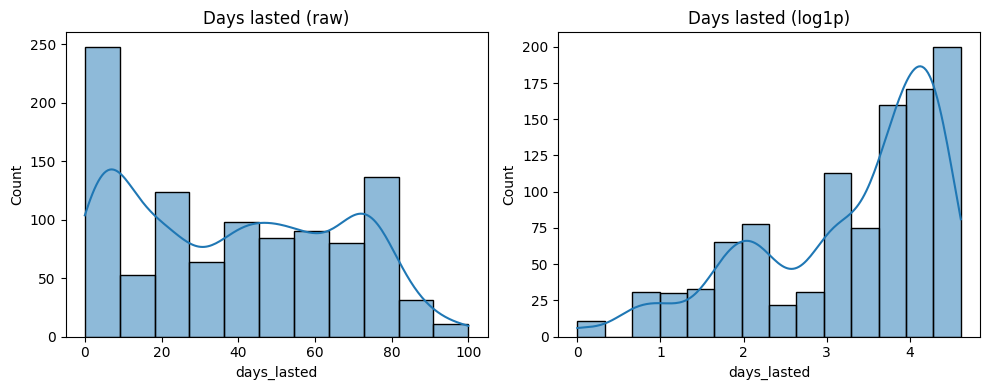

In [18]:

import scipy.stats as stats

numeric_cols = ['days_lasted', 'age', 'viewers', 'imdb_rating', 'n_ratings']
eda_num = (
    sur.merge(epi[['season','episode','viewers','imdb_rating','n_ratings']],
              on='season', how='left')
)

eda_num[numeric_cols].describe()

# Skewness table
skew_vals = eda_num[numeric_cols].skew()
skew_vals.to_frame('skewness').sort_values('skewness', ascending=False)
# Example: distribution + log-transform for days_lasted
fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.histplot(eda_num['days_lasted'], kde=True, ax=axes[0])
axes[0].set_title('Days lasted (raw)')

sns.histplot(np.log1p(eda_num['days_lasted']), kde=True, ax=axes[1])
axes[1].set_title('Days lasted (log1p)')

plt.tight_layout()
plt.show()



**Inference:**



**Days_lasted is strongly right‑skewed.**

Most contestants last relatively few days, and a small number last very long, which is why the raw histogram piles up on the left and stretches out to the right.

**A log transform makes the distribution more balanced.**

After applying log, the histogram looks more symmetric, which is useful for methods that assume roughly normal features (e.g., distance based clustering on numeric variables).



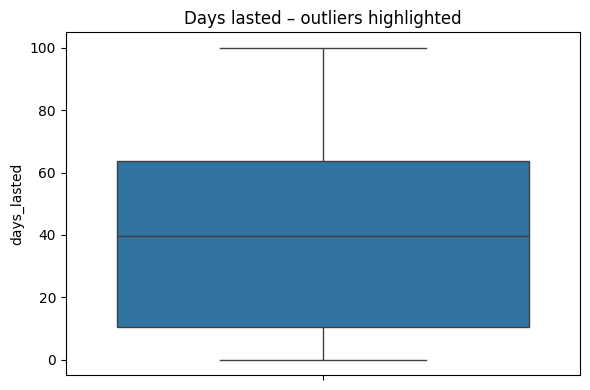

In [19]:
from scipy.stats import zscore
sur['days_lasted_z'] = zscore(sur['days_lasted'])

# Flag extreme outliers (e.g., |z| > 2.5)
outliers = sur[sur['days_lasted_z'].abs() > 2.5][
    ['season', 'name', 'days_lasted', 'days_lasted_z', 'reason_category']
]
outliers.head()
plt.figure(figsize=(6,4))
sns.boxplot(data=sur, y='days_lasted')
plt.title('Days lasted – outliers highlighted')
plt.tight_layout()
plt.show()



**Inference:** These outliers are the people who lasted dramatically longer than the median, reinforcing that survival time has a long right tail. The extreme cases are exactly the “champions".This justifies treating winners and top finishers as a distinct group when you do clustering or segmentation later.



**Average survival days by age band and tap‑out reason**

In [20]:
# Create age bands
bins = [18, 30, 40, 50, 65]
labels = ['18–29','30–39','40–49','50–65']
sur['age_band'] = pd.cut(sur['age'], bins=bins, labels=labels, right=False)

age_reason = (
    sur.groupby(['age_band','reason_category'])['days_lasted']
       .agg(['count','mean','median'])
       .reset_index()
)
age_reason


/tmp/ipython-input-4261077927.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sur.groupby(['age_band','reason_category'])['days_lasted']


,age_band,reason_category,count,mean,median
0,18–29,Family / personal,6,39.833333,38.0
1,18–29,Loss of inventory,1,4.000000,4.0
2,18–29,Medical / health,6,29.333333,7.5
3,30–39,Family / personal,12,27.333333,33.5
4,30–39,Loss of inventory,1,72.000000,72.0
5,30–39,Medical / health,18,38.833333,42.5
6,40–49,Family / personal,15,26.933333,22.0
7,40–49,Loss of inventory,1,10.000000,10.0
8,40–49,Medical / health,18,40.500000,41.5
9,50–65,Family / personal,3,43.666667,36.0


**Mean days_lasted by age band and tap‑out reason**

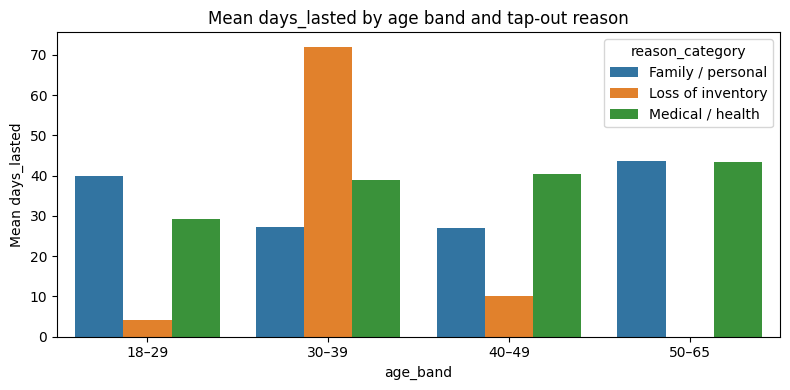

In [21]:
plt.figure(figsize=(8,4))
sns.barplot(
    data=age_reason,
    x='age_band',
    y='mean',
    hue='reason_category'
)
plt.title('Mean days_lasted by age band and tap‑out reason')
plt.ylabel('Mean days_lasted')
plt.tight_layout()
plt.show()


**Inference:**
Across most age bands, contestants who leave for family or personal reasons tend to have higher mean survival days than those who exit due to medical issues or inventory loss.

The 30–39 group that taps out for loss of inventory stands out with especially long average stays, suggesting that some highly resilient players only leave when gear failure, not physical or emotional limits, forces an exit.

**Episodes that over‑ and under‑perform relative to their season’s average viewership**

In [22]:
# Episode performance vs season average
epi_perf = epi.copy()
epi_perf['season_mean_viewers'] = epi_perf.groupby('season')['viewers'].transform('mean')
epi_perf['viewers_diff'] = epi_perf['viewers'] - epi_perf['season_mean_viewers']

# Top over‑performers and under‑performers
top_eps = epi_perf.sort_values('viewers_diff', ascending=False).head(5)[
    ['season','episode','title','viewers','season_mean_viewers','viewers_diff']
]
bottom_eps = epi_perf.sort_values('viewers_diff').head(5)[
    ['season','episode','title','viewers','season_mean_viewers','viewers_diff']
]
top_eps, bottom_eps


(    season  episode               title  viewers  season_mean_viewers  \
 10       1       11             Triumph    2.375             1.969700   
 33       3       10              Day 87    2.117             1.720400   
 82       8        7          Surrounded    1.705             1.461750   
 50       5        7  Desperate Measures    1.661             1.420400   
 74       7       10    Pins and Needles    1.546             1.306818   
 
     viewers_diff  
 10      0.405300  
 33      0.396600  
 82      0.243250  
 50      0.240600  
 74      0.239182  ,
     season  episode             title  viewers  season_mean_viewers  \
 24       3        1        A New Land    1.245             1.720400   
 0        1        1  And So It Begins    1.582             1.969700   
 1        1        2   Of Wolf and Man    1.697             1.969700   
 62       6        9    The Ice Cometh    0.989             1.224545   
 47       5        4  Mongolia's Wrath    1.188             1.420400   
 

**Episode viewers vs season average**

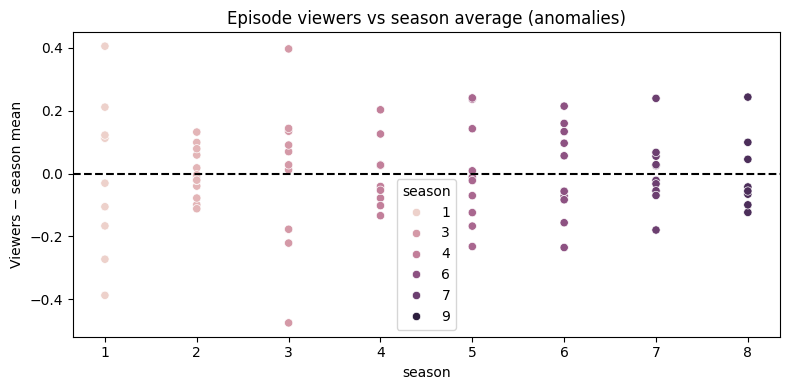

In [23]:
plt.figure(figsize=(8,4))
sns.scatterplot(
    data=epi_perf,
    x='season',
    y='viewers_diff',
    hue='season'
)
plt.axhline(0, color='black', linestyle='--')
plt.title('Episode viewers vs season average (anomalies)')
plt.ylabel('Viewers − season mean')
plt.tight_layout()
plt.show()


**Inference:** Each point shows how much an episode’s viewers differ from its own season’s average. This highlights over‑performing and under‑performing episodes within each season, helping you identify which episodes attracted unusually high or low audiences given their season baseline.

## **EDA - ABBINAYA**

**Season level summary table**

In [24]:
season_summary = df.groupby(['version','season','location'], as_index=False).agg(
    n_contestants      = ('name','nunique'),
    mean_days_lasted   = ('days_lasted','mean'),
    median_days_lasted = ('days_lasted','median'),
    early_exit_rate    = ('days_lasted', lambda s: (s < 20).mean()),
    med_evacuated_rate = ('medically_evacuated', lambda s: s.astype(int).mean()),
    mean_viewers       = ('viewers','mean'),
    mean_imdb_rating   = ('imdb_rating','mean'),
    total_n_ratings    = ('n_ratings','sum')
)

season_summary.round(2)

,version,season,location,n_contestants,mean_days_lasted,median_days_lasted,early_exit_rate,med_evacuated_rate,mean_viewers,mean_imdb_rating,total_n_ratings
0,US,1,Quatsino,10,21.60,7.0,0.60,0.00,1.97,7.67,1015.45
1,US,2,Quatsino,10,34.40,28.0,0.30,0.10,1.62,7.59,667.69
2,US,3,Patagonia,10,54.30,61.5,0.20,0.30,1.72,7.82,612.00
3,US,4,Quatsino,14,31.43,14.0,0.57,0.29,1.51,7.30,670.60
4,US,5,Selenge Province,10,30.10,31.5,0.30,0.30,1.42,8.00,514.00
5,US,6,Great Slave Lake,10,45.40,50.0,0.30,0.50,1.22,8.02,589.09
6,US,7,Great Slave Lake,10,49.90,44.0,0.20,0.30,1.31,8.34,739.09
7,US,8,Chilko Lake,10,41.20,30.5,0.20,0.30,1.46,7.78,577.27
8,US,9,Nunatsiavut,10,46.10,44.5,0.10,0.30,NaN,7.93,276.67


* Turns the raw contestant data into one row per season, so seasons can be compared directly.
* Hardness is captured by average and median days lasted, early‑exit rate, and medical‑evacuation rate.
* This is appropriate because the question is about seasons, so simple season‑level summaries are clearer and more reliable than complex models.
* The summary shows Season 1 with highest viewers but only moderate difficulty/ratings.
* Harder seasons do not always draw more viewers, suggesting extreme difficulty may appeal to a smaller, more devoted audience rather than a broad one.
* Missing viewer data for Season 9 might cause some gaps, so ratings became especially important for comparing that season.

**Hardness vs IMDb rating**

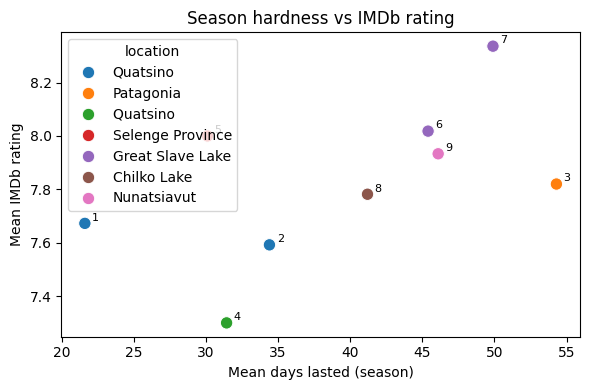

In [25]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=season_summary,
    x='mean_days_lasted', y='mean_imdb_rating',
    hue='location', s=80
)

for _, row in season_summary.iterrows():
    plt.text(row['mean_days_lasted']+0.5,
             row['mean_imdb_rating']+0.01,
             int(row['season']), fontsize=8)

plt.title('Season hardness vs IMDb rating')
plt.xlabel('Mean days lasted (season)')
plt.ylabel('Mean IMDb rating')
plt.tight_layout()
plt.show()


* This plot compares season hardness with average IMDb rating, with points colored by location and labeled by season number.
* There is a clear upward trend, seasons where contestants last longer on average generally receive higher IMDb ratings.
* Quatsino seasons have shorter stays and lower ratings, while tougher locations such as Great Slave Lake and Nunatsiavut have higher mean survival with some of the strongest ratings.
* This suggests that audiences tend to reward seasons that feel more demanding and sustained, at least in terms of quality, even if overall viewership does not always rise with hardness.

**Hardness vs viewers**

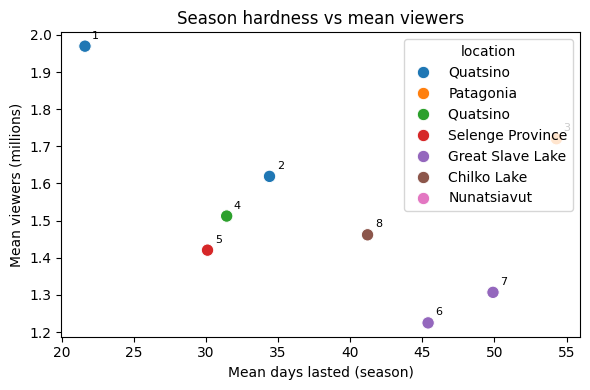

In [26]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=season_summary,
    x='mean_days_lasted', y='mean_viewers',
    hue='location', s=80
)

for _, row in season_summary.iterrows():
    plt.text(row['mean_days_lasted']+0.5,
             row['mean_viewers']+0.02,
             int(row['season']), fontsize=8)

plt.title('Season hardness vs mean viewers')
plt.xlabel('Mean days lasted (season)')
plt.ylabel('Mean viewers (millions)')
plt.tight_layout()
plt.show()


* This plot compares season hardness with average viewers, again with points labeled by season and colored by location.
* Unlike IMDb ratings, viewership does not increase with hardness, Season 1, which is relatively easier, has the highest mean audience, while some of the hardest seasons are in the lower‑viewership range.
* Later seasons in harsher locations appear to trade broad reach for a smaller audience, suggesting that extreme difficulty and risk may create a more niche but devoted viewership rather than mass appeal.

**Reason composition by season**

In [27]:
# Drop rows without a reason_category
tmp = df.dropna(subset=['reason_category'])

# Counts by season and reason
tmp_counts = (tmp
    .groupby(['season','reason_category'])
    .size()
    .reset_index(name='count'))

# Convert counts to shares within each season
tmp_counts['share'] = tmp_counts.groupby('season')['count'].transform(
    lambda x: x / x.sum()
)

reason_by_season = tmp_counts[['season','reason_category','share']]
reason_by_season.head()


,season,reason_category,share
0,1,Family / personal,0.777778
1,1,Loss of inventory,0.111111
2,1,Medical / health,0.111111
3,2,Family / personal,0.666667
4,2,Medical / health,0.333333


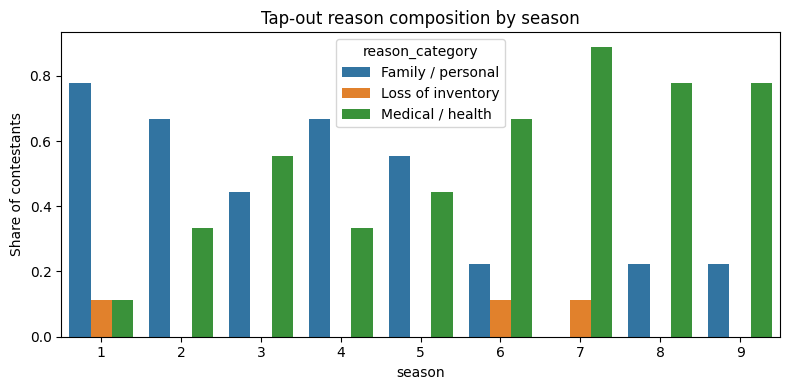

In [28]:
plt.figure(figsize=(8,4))
sns.barplot(
    data=reason_by_season,
    x='season', y='share', hue='reason_category'
)
plt.title('Tap-out reason composition by season')
plt.ylabel('Share of contestants')
plt.tight_layout()
plt.show()


* This chart shows, for each season, how the reasons for tapping out break down into family/personal, loss of inventory, and medical/health.
* Early seasons are dominated by family/personal exits, while later seasons, especially 6–9, have a much higher share of medical tap‑outs, indicating that the show becomes physically harsher over time.
* Loss‑of‑inventory exits stay relatively rare but spike in a few seasons, suggesting that gear failures are an occasional but important trigger rather than a constant pressure.

**Days lasted by reason_category**

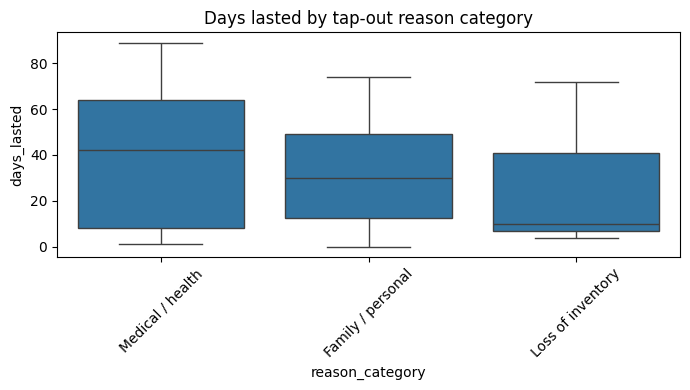

In [29]:
plt.figure(figsize=(7,4))
sns.boxplot(
    data=df,
    x='reason_category', y='days_lasted'
)
plt.xticks(rotation=45)
plt.title('Days lasted by tap-out reason category')
plt.tight_layout()
plt.show()


*This boxplot compares how long contestants last before tapping out, grouped by the reason category.
* Medical/health exits have the highest median and widest spread in days lasted, meaning many contestants push themselves far before being pulled for health reasons.
* Family/personal exits occur at moderate survival durations, while loss‑of‑inventory exits cluster at lower days, suggesting gear failures tend to force earlier, less “complete” runs.

**Season difficulty over time**

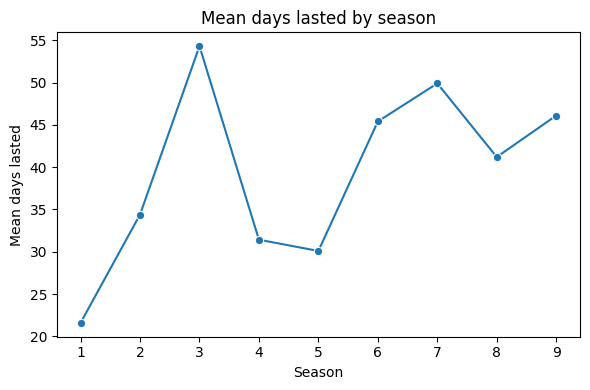

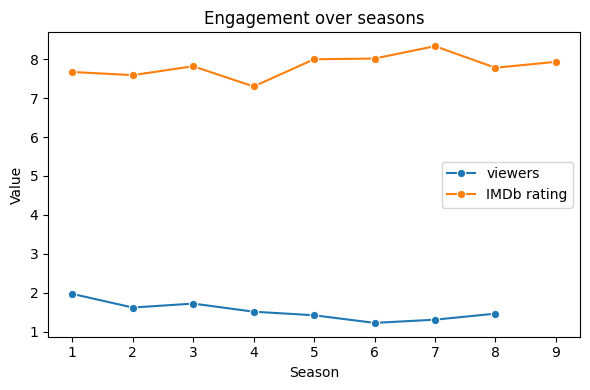

In [30]:
plt.figure(figsize=(6,4))
sns.lineplot(
    data=season_summary.sort_values('season'),
    x='season', y='mean_days_lasted', marker='o'
)
plt.title('Mean days lasted by season')
plt.xlabel('Season')
plt.ylabel('Mean days lasted')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.lineplot(
    data=season_summary.sort_values('season'),
    x='season', y='mean_viewers', marker='o', label='viewers'
)
sns.lineplot(
    data=season_summary.sort_values('season'),
    x='season', y='mean_imdb_rating', marker='o', label='IMDb rating'
)
plt.title('Engagement over seasons')
plt.xlabel('Season')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


* The engagement over seasons plot shows that average viewers decline after Season 1 and never fully return to the initial level, while IMDb ratings generally trend upward and peak around Seasons 5–7.
* This suggests the show evolves toward a smaller but more appreciative audience, fewer people watch later seasons, but those who do tend to rate them more highly.
* The mean days lasted by season plot shows that average survival time increases sharply by Season 3, dips in Season 4–5, then rises again in Seasons 6–7 before a slight drop in Season 8 and rebound in Season 9.
* Taken together, these visuals indicate that, over time, seasons become generally harder in terms of survival while engagement shifts from broad early curiosity to more focused, high‑rating interest among continuing viewers.

**Correlation between hardness and engagement metrics**

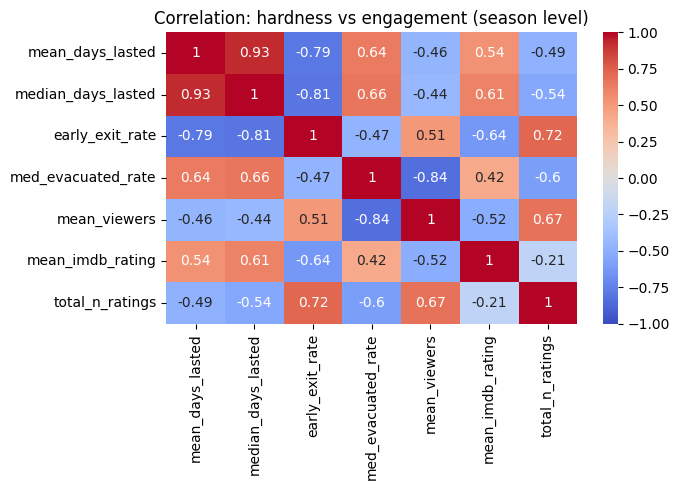

In [31]:
cols = [
    'mean_days_lasted','median_days_lasted',
    'early_exit_rate','med_evacuated_rate',
    'mean_viewers','mean_imdb_rating','total_n_ratings'
]

plt.figure(figsize=(7,5))
sns.heatmap(
    season_summary[cols].corr(),
    annot=True, cmap='coolwarm', vmin=-1, vmax=1
)
plt.title('Correlation: hardness vs engagement (season level)')
plt.tight_layout()
plt.show()


* This heatmap shows correlations between hardness metrics (days lasted, early exits, medical evacuations) and engagement metrics (viewers, IMDb rating, total ratings) at the season level.
* Seasons where contestants last longer and have fewer early exits tend to receive higher IMDb ratings and more total ratings, but they are weakly or negatively related to mean viewers, reinforcing the pattern that difficulty is valued by a smaller, more engaged audience rather than a larger one.

**Hierarchical Clustering**

In [32]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# choose hardness + engagement features
feat_cols = [
    'mean_days_lasted','median_days_lasted',
    'early_exit_rate','med_evacuated_rate',
    'mean_viewers','mean_imdb_rating','total_n_ratings'
]

# drop seasons with missing mean_viewers (or fill with mean if you prefer)
season_clust = season_summary.dropna(subset=['mean_viewers']).copy()

X = season_clust[feat_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


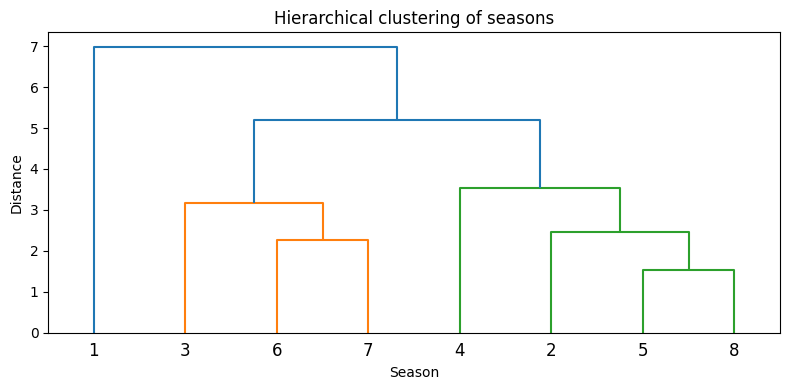

In [33]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(8,4))
dendrogram(Z, labels=season_clust['season'].to_numpy())
plt.title('Hierarchical clustering of seasons')
plt.xlabel('Season')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


In [34]:
# 2 clusters
season_clust['cluster_k2'] = fcluster(Z, 2, criterion='maxclust')
# 3 clusters
season_clust['cluster_k3'] = fcluster(Z, 3, criterion='maxclust')

# look at which season is in which group
season_clust[['season','cluster_k2','cluster_k3']]


,season,cluster_k2,cluster_k3
0,1,2,3
1,2,1,2
2,3,1,1
3,4,1,2
4,5,1,2
5,6,1,1
6,7,1,1
7,8,1,2


In [35]:
def clust_summary(label):
    return (season_clust
            .groupby(label)[feat_cols]
            .mean()
            .round(2))

clust_summary('cluster_k2')
clust_summary('cluster_k3')


,mean_days_lasted,median_days_lasted,early_exit_rate,med_evacuated_rate,mean_viewers,mean_imdb_rating,total_n_ratings
cluster_k3,,,,,,,
1,49.87,51.83,0.23,0.37,1.42,8.06,646.73
2,34.28,26.00,0.34,0.25,1.50,7.67,607.39
3,21.60,7.00,0.60,0.00,1.97,7.67,1015.45


**Cluster 1 (seasons 3,6,7)**
* Very high hardness - mean days ≈ 50, median ≈ 52, early_exit_rate low (0.23), med_evacuated_rate relatively high (0.37).
* Lower viewers (≈ 1.42M) but highest IMDb ratings (≈ 8.06).

**Interpretation:** hard seasons with longer survival and more medical taps, attracting a smaller but very satisfied audience.

**Cluster 2 (seasons 2,4,5,8)**
* Moderate hardness: mean days ≈ 34, early_exit_rate ≈ 0.34, med_evacuated_rate ≈ 0.25.
* Viewers around 1.5M and IMDb ratings mid‑range (≈ 7.67).

**Interpretation:** medium‑difficulty, medium‑engagement seasons.

**Cluster 3 (season 1 only)**
* Easiest: mean days ≈ 21.6, median 7, very high early_exit_rate (0.60), no medical evacuations.
* Highest viewership (≈ 1.97M) but only mid ratings (7.67).

**Interpretation:** launch season with big audience but relatively easy survival and less impressive ratings.

# **K MEANS**

**Prepare & Normalise**

In [36]:
from sklearn.preprocessing import StandardScaler
import numpy as np

feat_cols = [
    'mean_days_lasted','median_days_lasted',
    'early_exit_rate','med_evacuated_rate',
    'mean_viewers','mean_imdb_rating','total_n_ratings'
]

season_km = season_summary.dropna(subset=['mean_viewers']).copy()

X = season_km[feat_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


**Elbow Method (K = 1-5)**

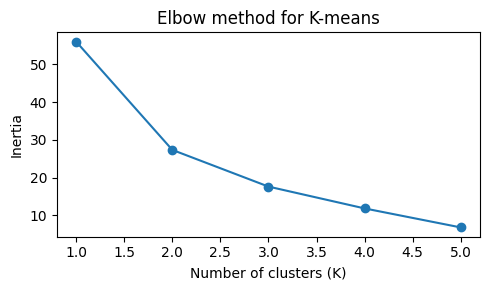

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
Ks = range(1, 6)

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(5,3))
plt.plot(Ks, inertias, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow method for K-means')
plt.tight_layout()
plt.show()


**Silhouette Scores**

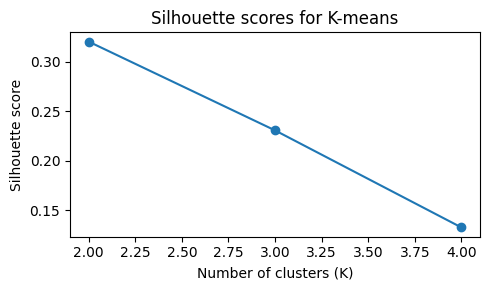

In [38]:
from sklearn.metrics import silhouette_score

sil_scores = []
Ks = range(2, 5)   # cannot compute silhouette for K=1

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(5,3))
plt.plot(Ks, sil_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores for K-means')
plt.tight_layout()
plt.show()


* The elbow plot drops sharply from K=1 to K=2 and then flattens, so 2 or 3 clusters should be good.
* The silhouette scores are highest at K=2, and decrease steadily for K=3 and K=4, which means the separation between clusters is clearest when the data is split into two groups.
​* Given the tiny sample (only 8–9 seasons), K=2 is the safest choice

**Fit K‑means with K=2**

In [39]:
from sklearn.cluster import KMeans

feat_cols = [
    'mean_days_lasted','median_days_lasted',
    'early_exit_rate','med_evacuated_rate',
    'mean_viewers','mean_imdb_rating','total_n_ratings'
]

season_km = season_summary.dropna(subset=['mean_viewers']).copy()

X = season_km[feat_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k2 = KMeans(n_clusters=2, random_state=42, n_init=20)
season_km['kmeans_k2'] = k2.fit_predict(X_scaled) + 1   # clusters 1 and 2

season_km[['season','kmeans_k2']]


,season,kmeans_k2
0,1,2
1,2,2
2,3,1
3,4,2
4,5,1
5,6,1
6,7,1
7,8,1


In [40]:
km2_summary = (season_km
               .groupby('kmeans_k2')[feat_cols]
               .mean()
               .round(2))
km2_summary


,mean_days_lasted,median_days_lasted,early_exit_rate,med_evacuated_rate,mean_viewers,mean_imdb_rating,total_n_ratings
kmeans_k2,,,,,,,
1,44.18,43.50,0.24,0.34,1.43,7.99,606.29
2,29.14,16.33,0.49,0.13,1.70,7.52,784.58


**Cluster 1 (3,5,6,7,8)**
* Higher hardness: mean_days_lasted ≈ 44, median ≈ 44, early_exit_rate low (0.24), med_evacuated_rate higher (0.34).
* Engagement pattern: lower mean_viewers (≈ 1.43M) but higher mean_imdb_rating (≈ 7.99).

**Cluster 2 (1,2,4)**

* ower hardness: mean_days_lasted ≈ 29, median ≈ 16, early_exit_rate high (0.49), med_evacuated_rate lower (0.13).
* Engagement pattern: higher mean_viewers (≈ 1.70M) but lower mean_imdb_rating (≈ 7.52).

**Interpretation**: with K=2, K‑means clearly separates “easier, high‑viewership, lower‑rating” early seasons from “harder, lower‑viewership, higher‑rating” later seasons, matching the story you saw with hierarchical clustering.

**If we try k=3 , will we get a similar cluster to hierarchical?**

In [41]:
best_k = 3   # change if your plots suggest 2

km_final = KMeans(n_clusters=best_k, random_state=42, n_init=20)
season_km['kmeans_cluster'] = km_final.fit_predict(X_scaled) + 1  # +1 for nicer labels

season_km[['season','kmeans_cluster']]


,season,kmeans_cluster
0,1,3
1,2,2
2,3,1
3,4,2
4,5,1
5,6,1
6,7,1
7,8,1


In [42]:
km_summary = (season_km
              .groupby('kmeans_cluster')[feat_cols]
              .mean()
              .round(2))
km_summary


,mean_days_lasted,median_days_lasted,early_exit_rate,med_evacuated_rate,mean_viewers,mean_imdb_rating,total_n_ratings
kmeans_cluster,,,,,,,
1,44.18,43.5,0.24,0.34,1.43,7.99,606.29
2,32.91,21.0,0.44,0.19,1.57,7.45,669.15
3,21.60,7.0,0.60,0.00,1.97,7.67,1015.45


**Comparison between Hierarchical & K Means**

In [43]:
# merge labels by season
compare = (season_clust[['season','cluster_k3']]
           .merge(season_km[['season','kmeans_cluster']],
                  on='season', how='inner'))

compare


,season,cluster_k3,kmeans_cluster
0,1,3,3
1,2,2,2
2,3,1,1
3,4,2,2
4,5,2,1
5,6,1,1
6,7,1,1
7,8,2,1


* Season 1 is placed in cluster 3 by both methods, confirming it behaves as a unique “easy + high‑viewership” season.
* Seasons 3 and 6–7 are grouped into cluster 1 by both methods, forming a stable “harder, high‑rating” group.
* Seasons 2, 4 mostly fall into the same cluster type across methods indicating they behave as moderate, in‑between seasons.
* Season 5 and 8 are in‑between: they are not as easy as Season 1–2–4, but not as extreme as the hardest seasons.

Overall, the two algorithms produce very similar structures, which strengthens confidence that these three season types (easy, moderate, hard) are genuine patterns and not artifacts of one particular method.

**Chart for Findings and Interpretation**


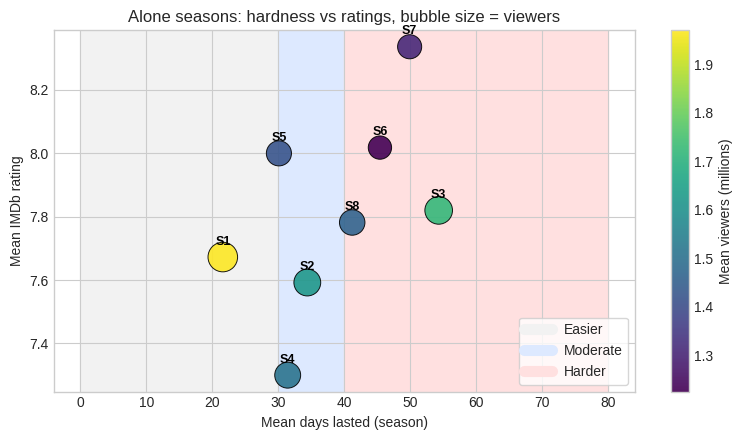

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

chart_df = season_summary.dropna(subset=['mean_viewers']).copy()

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8,4.5))

# clearer, solid difficulty bands
ax.axvspan(0, 30,  color='#f2f2f2', alpha=1.0, zorder=0)
ax.axvspan(30, 40, color='#dde9ff', alpha=1.0, zorder=0)
ax.axvspan(40, 80, color='#ffe0e0', alpha=1.0, zorder=0)  # fixed: color=...

# bubbles
sc = ax.scatter(
    chart_df['mean_days_lasted'],
    chart_df['mean_imdb_rating'],
    c=chart_df['mean_viewers'],
    s=chart_df['mean_viewers'] * 230,
    cmap='viridis',
    alpha=0.9,
    edgecolor='black',
    linewidth=0.7,
    zorder=2
)

# season labels placed slightly above each bubble
for _, row in chart_df.iterrows():
    ax.text(
        row['mean_days_lasted'],
        row['mean_imdb_rating'] + 0.03,
        f"S{int(row['season'])}",
        ha='center',
        va='bottom',
        fontsize=9,
        weight='bold',
        color='black',
        zorder=3
    )

# difficulty legend (manual patches)
easy = plt.Line2D([0], [0], color='#f2f2f2', lw=8, label='Easier')
mod  = plt.Line2D([0], [0], color='#dde9ff', lw=8, label='Moderate')
hard = plt.Line2D([0], [0], color='#ffe0e0', lw=8, label='Harder')
ax.legend(handles=[easy, mod, hard], loc='lower right', frameon=True)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Mean viewers (millions)')

ax.set_xlabel('Mean days lasted (season)')
ax.set_ylabel('Mean IMDb rating')
ax.set_title('Alone seasons: hardness vs ratings, bubble size = viewers')

plt.tight_layout()
plt.show()


**Reference**

1. [wiki page](https://en.wikipedia.org/wiki/Alone_(TV_series)
2. [stat.cmu](https://www.stat.cmu.edu/capstoneresearch/fall2023/315files_f23/team10.html)
3. [stackoverflow..com](https://stackoverflow.com/questions)
4. [Clustering - Sckit](https://scikit-learn.org/stable/modules/clustering.html)

**Generative AI Disclosure**

* ChatGPT was used selectively for writing and coding assistance, under full team validation and oversight.
* Code standardization: Helped align style and reduce warnings; all notebooks were re‑run end‑to‑end by the team to verify correctness.
* Writing and documentation: Assisted with grammar and wording; every numeric statement was cross‑checked against our own tables and figures, and text was kept only when it matched our results.
* Visualization refinement: Suggested clearer axis labels, legends, and color choices; all plots were regenerated directly from our data and reviewed by the team.
* Generative AI was not used to derive conclusions or interpret results; final interpretations and decisions are entirely our own.


**Links to ChatGPT Conversation:**

1. [Chat GPT LINK ](https://chatgpt.com/share/69850827-520c-8010-ac51-ffb0486a440e)